**Training Accuracy =   99.98%**    
**Validation Accuracy = 93.09%**

**Changes Made:**
**1- Upsampling by a factor of (2,2).**

**2- Additional Dense Layers of 512, 128, 64, and 32 layers.**

**3- experimented with a different optimizer 'RMSprop' instead of Adam, but chose Adam optimizer eventually.**

**4- Initiated the learning rate at 0.0001**

**5- Applied reducing of learning rate on Plateau with a factor = 0.3 and patience = 2, to improve model convergence by dynamically adjusting the learning rate based on performance during training.**

**6- Increased batch size to 128.**

**7- Applied early stopping to stop overfitting.**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam,RMSprop

In [ ]:
# Enable GPU from Google Colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))
    print('Using GPU')
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


Found GPU at: /device:GPU:0
Using GPU


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [ ]:
# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


After many experiments, I found that **upsampling the input images by a factor of (2,2) to achieve an input shape of (64,64,3) was beneficial**. This adjustment eased computational burden while still increasing spatial resolution. It struck a balance, enhancing model performance without significantly prolonging the training process.

To enhance the model's capacity to learn complex patterns, I introduced **additional dense layers with 512, 128, 64, and 32 neurons**, respectively. These layers provide the model with more parameters and non-linear transformations, potentially enabling it to capture intricate features in the data.

I initiated the **training with a learning rate of 0.0001**. Additionally, I incorporated the **ReduceOnPlateau function to dynamically adjust the learning rate during training**. This strategy ensures that the learning rate is reduced when necessary.

In [ ]:
# Define the model
model = Sequential([
    Input(shape=(32, 32, 3)),
    UpSampling2D(size=(2, 2)),
    VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet', pooling='none'),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_2 (UpSamplin  (None, 64, 64, 3)         0         
 g2D)                                                            
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 128)              

**I added a learning rate scheduler to reduce the learning rate with a factor of 0.3 such that since the initial learning rate is 0.0001 and factor=0.3, after the callback triggers a reduction, the learning rate will become 0.0001 * 0.3 = 0.00003.and chose min learning rate to be 1e^-7. The numbers were adjusted after trials**

**I also increased the batch size to 128, because bigger batch sizes can utilize the computational resources more efficiently and will lead to faster training.**

**I applied early stopping with patience = 5 to prevent overfitting, improve generalization and save training time.**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.3, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=40, validation_data = (x_test, y_test), batch_size=128, callbacks=[early_stopping,lr_scheduler])

Epoch 1/40
352/352 [==============================] - 58s 152ms/step - loss: 0.7908 - acc: 0.7327 - val_loss: 0.4832 - val_acc: 0.8420 - lr: 1.0000e-04
Epoch 2/40
352/352 [==============================] - 54s 152ms/step - loss: 0.3624 - acc: 0.8780 - val_loss: 0.3831 - val_acc: 0.8682 - lr: 1.0000e-04
Epoch 3/40
352/352 [==============================] - 52s 147ms/step - loss: 0.2282 - acc: 0.9238 - val_loss: 0.4042 - val_acc: 0.8617 - lr: 1.0000e-04
Epoch 4/40
352/352 [==============================] - 52s 148ms/step - loss: 0.1567 - acc: 0.9456 - val_loss: 0.3028 - val_acc: 0.8989 - lr: 1.0000e-04
Epoch 5/40
352/352 [==============================] - 52s 149ms/step - loss: 0.1096 - acc: 0.9627 - val_loss: 0.2842 - val_acc: 0.9123 - lr: 1.0000e-04
Epoch 6/40
352/352 [==============================] - 53s 149ms/step - loss: 0.0757 - acc: 0.9746 - val_loss: 0.3304 - val_acc: 0.9060 - lr: 1.0000e-04
Epoch 7/40
352/352 [==============================] - 52s 149ms/step - loss: 0.0639 - ac

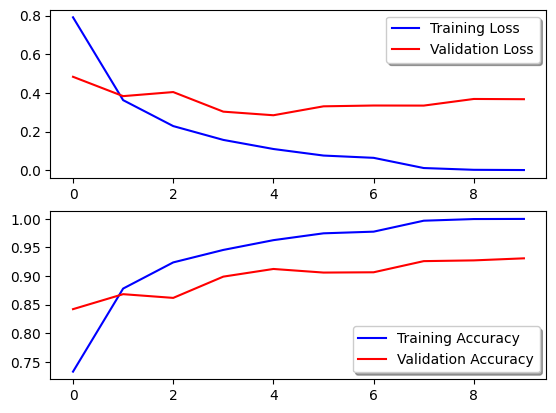

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)